## Q Analysis from a VSP - Basics

This notebook demonstrates a simple method of estimating Q from  
Vertical Seismic Profiling (VSP) data.  

The notebook uses the Spectral Ratio method. This involves measuring spectra at a target depth  
and at a shallower reference depth. Q is derived from the spectral ratios which are derived from  
the target and reference spectra.  

<img src="nb_images/QPicture1.png" width="400" height="400" align="left" />  
<br clear="left"/>   
<br>
<br>    

In [1]:
### The following 3 lines expand the useable area of the notebook
### Adjust percents to make bigger or smaller
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
display(HTML("<style>.output_result { max-width:75% !important; }</style>"))
#display(HTML("<style>.prompt { display:none !important; }</style>"))

# important geophysical imports
# I use several methods to load packages as examples

from io_vsp.segyin import readsegyio3
from plot_vsp.seisplots import wiggle_plot

# Best method is the one below, you always know where functions are coming from

import proc_vsp.sigproc as sgp
import proc_vsp.qtools as qtls
import plot_vsp.qplots as qplts


## Load the VSP SEG-Y file  

uses segyio data loading package
source and receiver locations are assumed to be in SEG-Y trace headers
user needs to supply basic geometry parameters
seismic replacement velocity
surface seismic datum elevation
drill floor elevation
source elevation
The sample rate read from the file needs to be QC'ed!!!

In [2]:
#################### get the ZVSP SEGY filename ############################

filename = (r'C:\Users\hooge\GitHub\Geophysics\VSP_Basics\data\down_flat.sgy')
# filename = (r'C:\Users\hooge\GitHub\Geophysics\VSP_Basics\data\zstack_q.sgy')    
################### input desired geometry parameters ######################

RepVel= 5000     # replacement velocity
SRD_ASL = 0    # SRD elevation above sea level
DF_ASL = 0    # drill floor elevation ASL
SrcElev = -10   # source elevation ASL

###################### run basic segy loading functions #################### 

file_head = 'n'         # print binary and text header to screen    
pr_thead = 'n'          # print a table of trace headers

data, numsamp, samprate, fs, theader =  readsegyio3(filename, file_head, 
                                        DF_ASL, SrcElev, SRD_ASL, pr_thead)


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲s̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:

 data shape : (270, 4800)  delta t : 1000.0
 data type : float32
 trace header file shape : (270, 15)
 samples : 4800  traces : 270  fs samprate hz :  1000.0 samprate microseconds :  1000 
 numsamp from headers :  4800
 first time header value :  [142.79] 
 first lag time A value : [0] 
 first lag time B value : [142]
 source depth from header trace 1 : [10.]


## Make a wiggle plot of upgoing and downgoing waves 

pol : n for normal or tape polarity, r to flip polarity  
spacing : 'z' is spread traces by receiver depth, else traces are evenly spaced  
skiplabel : plot every nth recever depth label at bottom of plot  
fs : sample rate in hertz, may be set elsewhere in notebook    
norm : plot trace normalization 'n' or 'y' 
scal : multiply every sample by this number to heat or cool plot  
info_wig : print diagnostic information to terminal  
timframe: 'owt' is one-way time, 'twt' is two-way time, 'flat' is flattened using a  


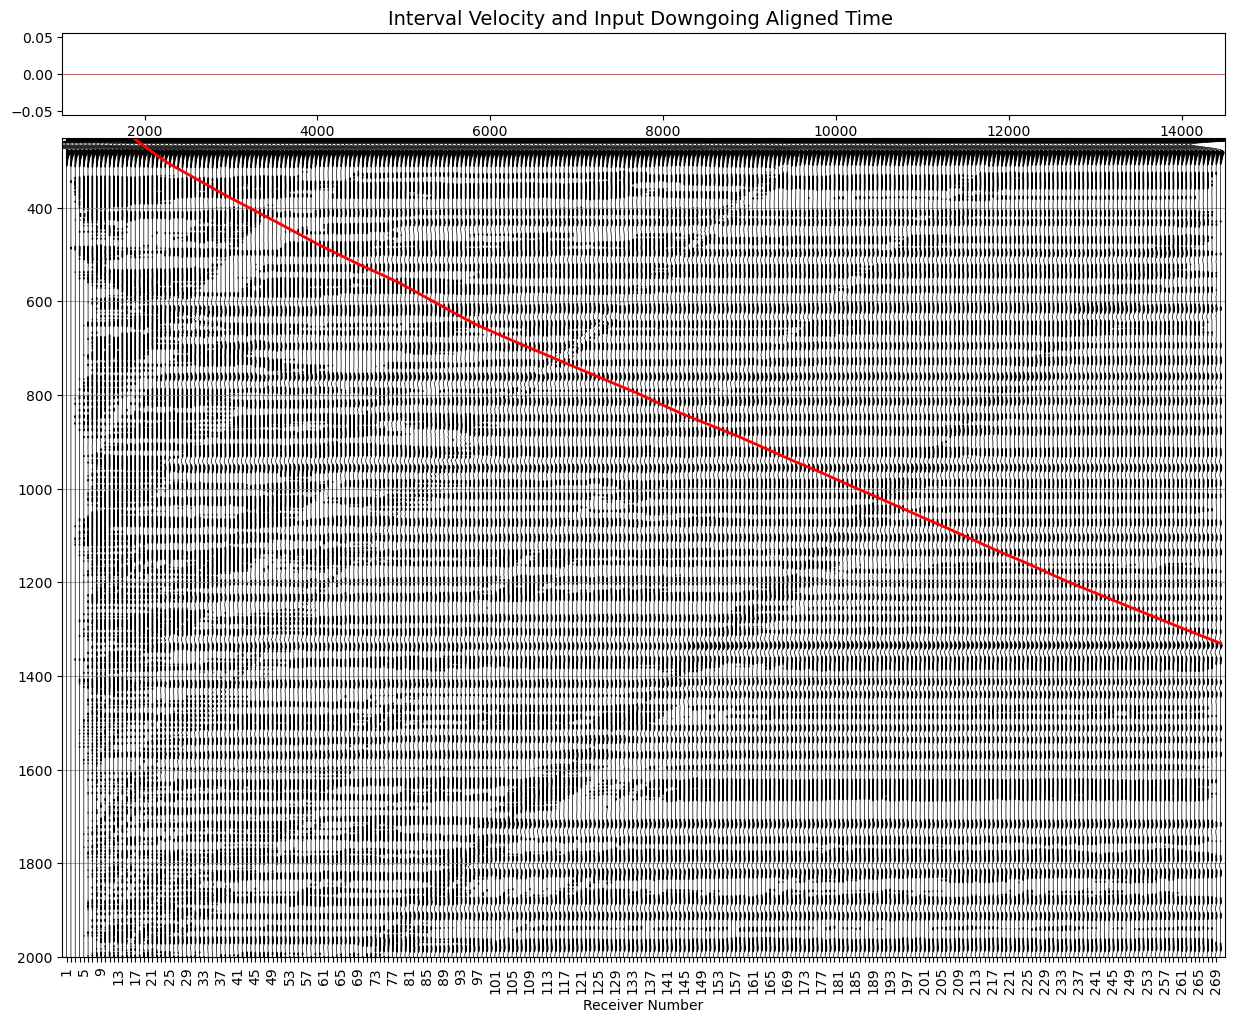

In [3]:
################## wiggle plot 

plot_params = {"pol":'n', 
                    "Tmax":2000, "Tmin":250, 
                    "first_rcv":1, 
                    "spacing":'r', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'y',
                    "scal":10, 
                    "title_top":'Input Downgoing Aligned Time ',
                    "info_wig":'n',
                    "timframe":'owt'} 
wiggle_plot(theader,data, **plot_params)    

## Q estimation demonstration

Q (or Quality Factor) describes the attenuation of seismic frequencies  
in the waves as they travel through the earth. See Morozov, 2019, 'Mechanics   
of Seismic Q' for an excellent discussion of the validity of Q measurements.

Attenuation is thought to be sensitive to lithology. Q may be  
strongly dependent on pore fluid properties. Stratigraphic filtering may also  
affect the data being used to estimate Q.  

VSPs observe the seismic waves at different depths in the earth. The spectra  
of the downgoing waves are routinel used to determine an apparent Q. See Morozov, 2019,  
'Mechanics of Seismic Q' for an excellent discussion on the validity of Q measurements.

Inverse Q filtering can restore some of the attenuated frequencies, improving  
the resolution of seismic. 

<img src="nb_images/Q_wiggle_spec.png" width="800" height="800" align="left" />  
<br clear="left"/>   
<br>
<br>    
A good reference article for deriving Q using spectral ratios 'Comparison of P- <br>
and S-wave velocities and Q's from VSP and sonic log data:' By De et al, Geophysics, 1994.  

We start with the following relationship:

$l𝑛(𝐴(𝑍,𝑓)/𝐴(𝑍_{0},𝑓) )=−𝜋𝑓(𝑇−𝑇_{0} ))/𝑄$

$A$ is the Fourier amplitude spectra of the reference trace and trace  
of interest at depths $Z_{0}$ and $Z$ respectively, $f$ is the frequency,  
$T$ is the arrival time at the two receiver depths

$𝑄=(−𝜋(𝑇−𝑇_{0}))/𝑠𝑙𝑜𝑝𝑒$ where slope is calculated by fitting a straight line to a graph  
of $l𝑛(𝐴(𝑍,𝑓)/𝐴(𝑍_{0},𝑓))$ versus frequency($f$)

### Simulating Q on a single trace (a what-if scenario)

This demonstration takes a single frequency spectrum (the 'reference') from a synthetic VSP and applies  
a Q filter based on the previous equations. The filtered spectrum for a simulated target is overlaid on  
the reference for comparison.  

The spectral ratios are calculated from the filtered(simulated) and the reference spectra.  
Q is calculated from the slope of the spectral ratio - frequency crossplot. It should match  
input Q value.  

Inputs are:  

1. The trace to be used
2. The time range on the trace where you would like to generate a spectrum
3. The frequency range to calculate the spectral ratios on
4. The Q value to be modelled
5. A velocity estimate between 2 receivers
6. A depth estimate between 2 receivers



̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0
 start: 500  stop: 1300
 slopew : [nan nan]  slopew.shape : (2,) Qeff : [nan]


c:\Users\hooge\GitHub\Geophysics\VSP_Basics\proc_vsp\qtools.py:97: RuntimeWarning: invalid value encountered in divide
  specrat=np.log(np.absolute(Qfwd)/np.absolute(X))


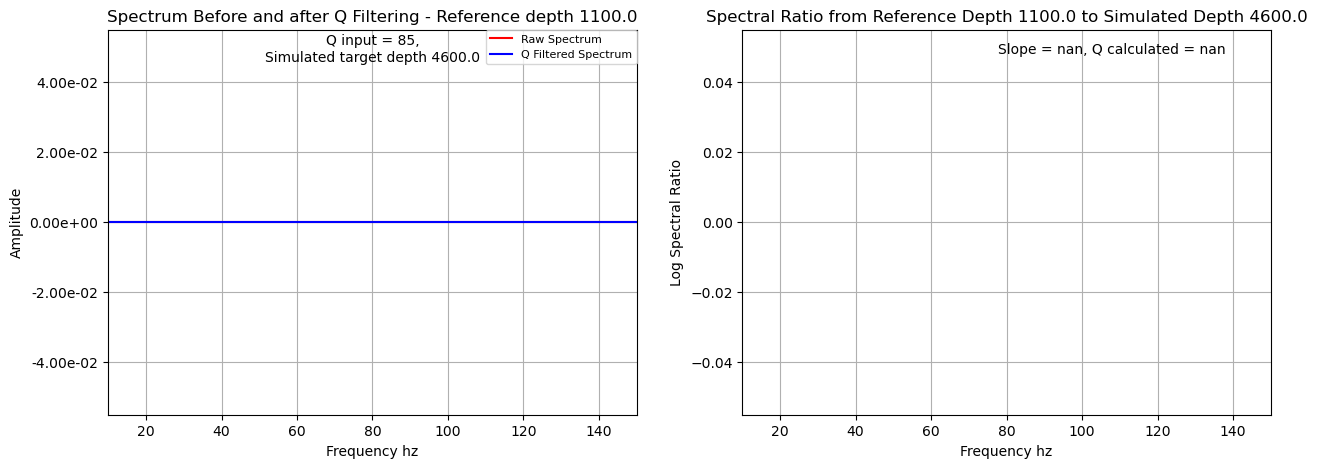

In [4]:
########################  Q Demonstration    ############################

trace = 1
time_win = 'y' # window trace prior to fft
time_range = [500, 800] # time window in ms for spectral estimation
freq_range = [10, 150]  # frequency range for plotting and calculation    
title_fran = 'Raw Z' 

qparams={"Q":85,
        "Vel":8000,  # average velocity between 2 receivers
        "Zint":3500, # depth interval to simulated target trace
        "savepng":'y',
        }
qtls.q_simulation(data, time_range, freq_range, theader, trace, fs, time_win, title_fran,**qparams)

## Q Estimation Using Spectral Ratios  

We use the same procedures as in the previous section, but this time  
a reference trace and a target trace at different depths are extracted from a real VSP.  

1. Calculate spectra for reference and target traces
2. Calculate spectral ratios between  the 2 spectra
3. Decide on a frequency range to analyze
 * where the spectral ratios do not swing wildly
3. Use the formula in previous section to calculate Q from the spectral ratio slope




̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0
 slopew : [-0.01630066  0.59147736]  slopew.shape : (2,) Qeff : [81.45261013]


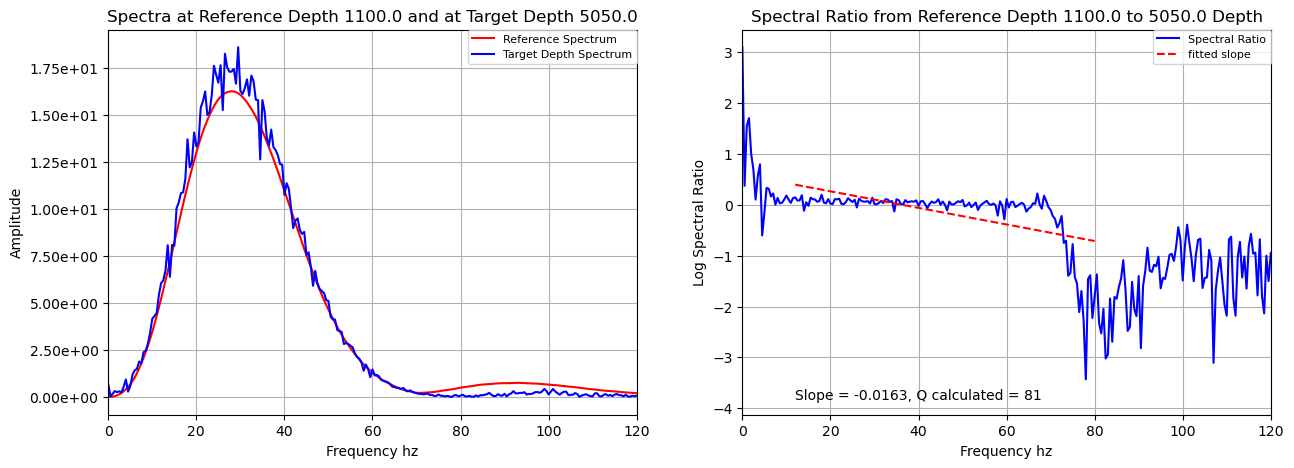

In [ ]:
########################  Q Estimation Spectral Ratios  ############################

qparams={"apply_window":'y',
            "time_min": 0,"time_max": 2000,
            "freq_min": 0,"freq_max":120, # for spectral plot limits
            "srfreq_min": 12,"srfreq_max":80, # for spectral ratio limits
            "trace_1": 1,# reference trace
            "trace_2":80, # deep target trace
            "savepng":'y',
        }
qtls.qest(data, theader,fs, **qparams)

### Make a fancy plot  

The parameters are broken into 2 sections, one for the Q estimation  
and one for plot parameters.  

Give it a try!


̲F̲r̲A̲n̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
fs : 1000.0
 slopew : [nan nan]  slopew.shape : (2,) Qeff : [nan]


c:\Users\hooge\GitHub\Geophysics\VSP_Basics\plot_vsp\qplots.py:241: RuntimeWarning: divide by zero encountered in divide
  specrat=np.log(Xtwo_mag/Xref_mag)
c:\Users\hooge\GitHub\Geophysics\VSP_Basics\plot_vsp\qplots.py:270: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax1.set_xlim(Xmin, Xmax) # extents must be set



̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 VSPdata.shape : (270, 4800)  (traces,samples)
 VSPdata type : float32
 Max an Min Amplitude VSPdata : 1.0 -0.74418294
 datascaled.shape  (270, 4800)  (traces,samples)
 thead shape : (270, 15)  (traces,header columns)


c:\Users\hooge\GitHub\Geophysics\VSP_Basics\plot_vsp\qplots.py:293: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax3.set_xlim(Xmin, Xmax) # extents must be set


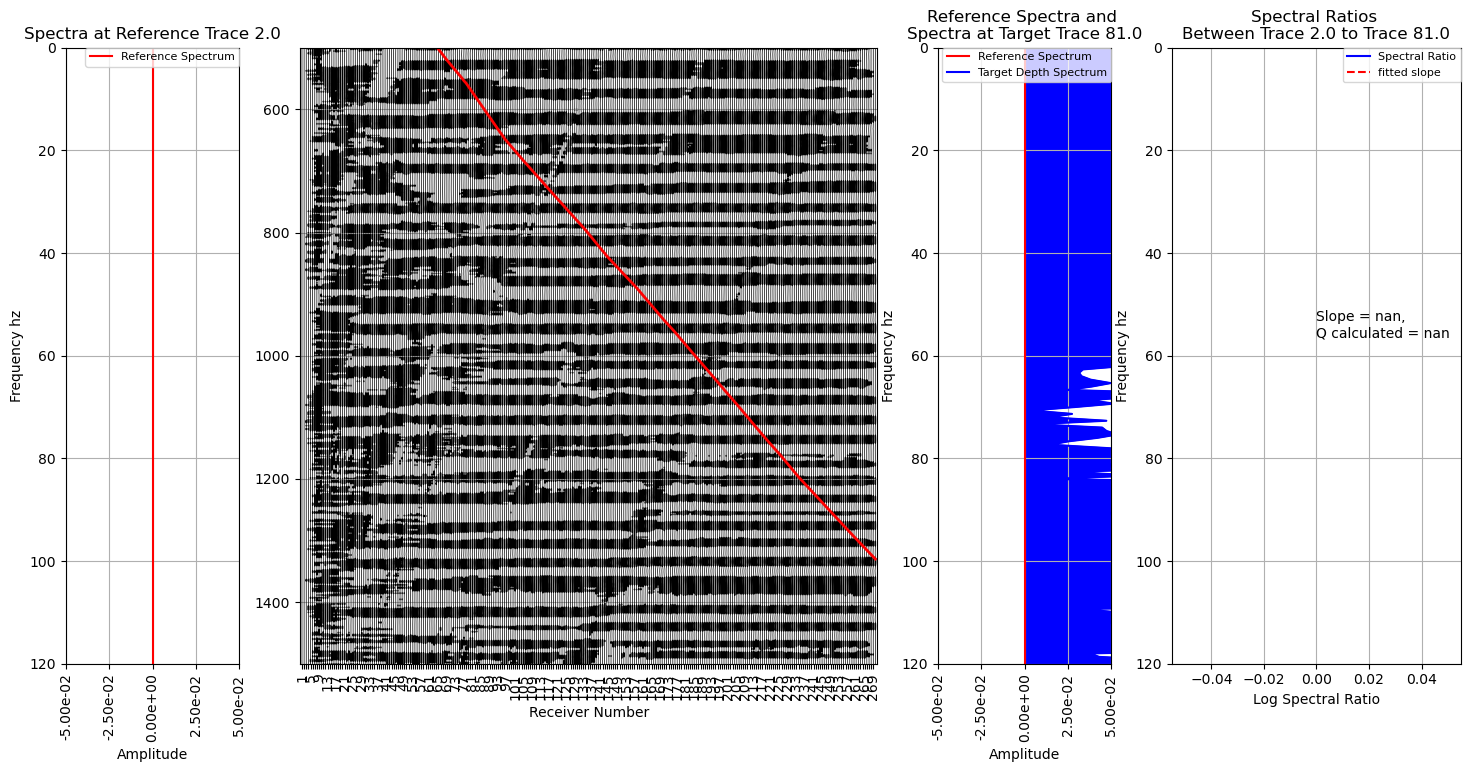

In [6]:
qfran_params={"apply_window":'y',
                "time_min": 500,"time_max": 1500,
                "freq_min": 0,"freq_max":120, # for spectral plot limits
                "srfreq_min": 12,"srfreq_max":80, # for spectral ratio limits
                "trace_1": 1,# reference trace
                "trace_2":80, # deep target trace
                "savepng":'y',
            }
qwig_params={'skiplabel':4,
                'norm':'y',
                'scal':5, 
                'title_top':'Input Downgoing Aligned Time ',
                'info_wig':'y'}
qplot_params={**qfran_params, **qwig_params}

qplts.q_datafran(data, theader,fs,**qplot_params)